# Задание 2.1 - Нейронные сети

В этом задании вы реализуете и натренируете настоящую нейроную сеть своими руками!

В некотором смысле это будет расширением прошлого задания - нам нужно просто составить несколько линейных классификаторов вместе!

<img src="https://i.redd.it/n9fgba8b0qr01.png" alt="Stack_more_layers" width="400px"/>

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
from dataset import load_svhn, random_split_train_val
from gradient_check import check_layer_gradient, check_layer_param_gradient, check_model_gradient
from layers import FullyConnectedLayer, ReLULayer
from model import TwoLayerNet
from trainer import Trainer, Dataset
from optim import SGD, MomentumSGD
from metrics import multiclass_accuracy

# Загружаем данные

И разделяем их на training и validation.

In [3]:
def prepare_for_neural_network(train_X, test_X):
    train_flat = train_X.reshape(train_X.shape[0], -1).astype(np.float) / 255.0
    test_flat = test_X.reshape(test_X.shape[0], -1).astype(np.float) / 255.0
    
    # Subtract mean
    mean_image = np.mean(train_flat, axis = 0)
    train_flat -= mean_image
    test_flat -= mean_image
    
    return train_flat, test_flat
    
train_X, train_y, test_X, test_y = load_svhn("data", max_train=10000, max_test=1000)    
train_X, test_X = prepare_for_neural_network(train_X, test_X)
# Split train into train and val
train_X, train_y, val_X, val_y = random_split_train_val(train_X, train_y, num_val = 1000)

/tmp/ipykernel_26934/2810386256.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_flat = train_X.reshape(train_X.shape[0], -1).astype(np.float) / 255.0
/tmp/ipykernel_26934/2810386256.py:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  test_flat = test_X.reshape(test_X.shape[0], -1).astype(np.float) / 255.0


# Как всегда, начинаем с кирпичиков

Мы будем реализовывать необходимые нам слои по очереди. Каждый слой должен реализовать:
- прямой проход (forward pass), который генерирует выход слоя по входу и запоминает необходимые данные
- обратный проход (backward pass), который получает градиент по выходу слоя и вычисляет градиент по входу и по параметрам

Начнем с ReLU, у которого параметров нет.

In [6]:
# TODO: Implement ReLULayer layer in layers.py
# Note: you'll need to copy implementation of the gradient_check function from the previous assignment

X = np.array([[1,-2,3],
              [-1, 2, 0.1]
              ])

assert check_layer_gradient(ReLULayer(), X)

Gradient check passed!


А теперь реализуем полносвязный слой (fully connected layer), у которого будет два массива параметров: W (weights) и B (bias).

Все параметры наши слои будут использовать для параметров специальный класс `Param`, в котором будут храниться значения параметров и градиенты этих параметров, вычисляемые во время обратного прохода.

Это даст возможность аккумулировать (суммировать) градиенты из разных частей функции потерь, например, из cross-entropy loss и regularization loss.

In [8]:
# TODO: Implement FullyConnected layer forward and backward methods
assert check_layer_gradient(FullyConnectedLayer(3, 4), X)
# TODO: Implement storing gradients for W and B
assert check_layer_param_gradient(FullyConnectedLayer(3, 4), X, 'W')
assert check_layer_param_gradient(FullyConnectedLayer(3, 4), X, 'B')

Gradient check passed!
Gradient check passed!
Gradient check passed!


## Создаем нейронную сеть

Теперь мы реализуем простейшую нейронную сеть с двумя полносвязным слоями и нелинейностью ReLU. Реализуйте функцию `compute_loss_and_gradients`, она должна запустить прямой и обратный проход через оба слоя для вычисления градиентов.

Не забудьте реализовать очистку градиентов в начале функции.

In [9]:
# TODO: In model.py, implement compute_loss_and_gradients function
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 3, reg = 0)
loss = model.compute_loss_and_gradients(train_X[:2], train_y[:2])

# TODO Now implement backward pass and aggregate all of the params
check_model_gradient(model, train_X[:2], train_y[:2])

Checking gradient for W_out
Gradient check passed!
Checking gradient for W_in
Gradient check passed!
Checking gradient for B_out
Gradient check passed!
Checking gradient for B_in
Gradient check passed!


True

Теперь добавьте к модели регуляризацию - она должна прибавляться к loss и делать свой вклад в градиенты.

In [10]:
# TODO Now implement l2 regularization in the forward and backward pass
model_with_reg = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 3, reg = 1e1)
loss_with_reg = model_with_reg.compute_loss_and_gradients(train_X[:2], train_y[:2])
assert loss_with_reg > loss and not np.isclose(loss_with_reg, loss), \
    "Loss with regularization (%2.4f) should be higher than without it (%2.4f)!" % (loss, loss_with_reg)

check_model_gradient(model_with_reg, train_X[:2], train_y[:2])

Checking gradient for W_out
Gradient check passed!
Checking gradient for W_in
Gradient check passed!
Checking gradient for B_out
Gradient check passed!
Checking gradient for B_in
Gradient check passed!


True

Также реализуем функцию предсказания (вычисления значения) модели на новых данных.

Какое значение точности мы ожидаем увидеть до начала тренировки?

In [12]:
# Finally, implement predict function!

# TODO: Implement predict function
# What would be the value we expect?
multiclass_accuracy(model_with_reg.predict(train_X[:30]), train_y[:30]) 

0.16666666666666666

# Допишем код для процесса тренировки

Если все реализовано корректно, значение функции ошибки должно уменьшаться с каждой эпохой, пусть и медленно. Не беспокойтесь пока про validation accuracy.

In [ ]:
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e1)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, SGD(), learning_rate = 1e-2)

# TODO Implement missing pieces in Trainer.fit function
# You should expect loss to go down every epoch, even if it's slow
loss_history, train_history, val_history = trainer.fit()

In [ ]:
plt.plot(train_history)
plt.plot(val_history)

# Улучшаем процесс тренировки

Мы реализуем несколько ключевых оптимизаций, необходимых для тренировки современных нейросетей.

## Уменьшение скорости обучения (learning rate decay)

Одна из необходимых оптимизаций во время тренировки нейронных сетей - постепенное уменьшение скорости обучения по мере тренировки.

Один из стандартных методов - уменьшение скорости обучения (learning rate) каждые N эпох на коэффициент d (часто называемый decay). Значения N и d, как всегда, являются гиперпараметрами и должны подбираться на основе эффективности на проверочных данных (validation data). 

В нашем случае N будет равным 1.

In [14]:
# TODO Implement learning rate decay inside Trainer.fit method
# Decay should happen once per epoch

model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-1)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, SGD(), learning_rate_decay=0.99)

initial_learning_rate = trainer.learning_rate
loss_history, train_history, val_history = trainer.fit()

assert trainer.learning_rate < initial_learning_rate, "Learning rate should've been reduced"
assert trainer.learning_rate > 0.5*initial_learning_rate, "Learning rate shouldn'tve been reduced that much!"

Loss: 2.249928, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.239042, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.298346, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.213825, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.271583, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.253327, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.185414, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.252596, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.303797, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.378797, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.331100, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.233551, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.263052, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.314094, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.225365, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.340751, Train acc

# Накопление импульса (Momentum SGD)

Другой большой класс оптимизаций - использование более эффективных методов градиентного спуска. Мы реализуем один из них - накопление импульса (Momentum SGD).

Этот метод хранит скорость движения, использует градиент для ее изменения на каждом шаге, и изменяет веса пропорционально значению скорости.
(Физическая аналогия: Вместо скорости градиенты теперь будут задавать ускорение, но будет присутствовать сила трения.)

```
velocity = momentum * velocity - learning_rate * gradient 
w = w + velocity
```

`momentum` здесь коэффициент затухания, который тоже является гиперпараметром (к счастью, для него часто есть хорошее значение по умолчанию, типичный диапазон -- 0.8-0.99).

Несколько полезных ссылок, где метод разбирается более подробно:  
http://cs231n.github.io/neural-networks-3/#sgd  
https://distill.pub/2017/momentum/

In [15]:
# TODO: Implement MomentumSGD.update function in optim.py

model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-1)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, MomentumSGD(), learning_rate=1e-4, learning_rate_decay=0.99)

# You should see even better results than before!
loss_history, train_history, val_history = trainer.fit()

Loss: 2.323071, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.279769, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.297404, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.300147, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.274831, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.279916, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.302557, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.286933, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.281800, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.336671, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.294825, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.270441, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.279329, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.269652, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.336324, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.336233, Train acc

# Ну что, давайте уже тренировать сеть!

## Последний тест - переобучимся (overfit) на маленьком наборе данных

Хороший способ проверить, все ли реализовано корректно - переобучить сеть на маленьком наборе данных.  
Наша модель обладает достаточной мощностью, чтобы приблизить маленький набор данных идеально, поэтому мы ожидаем, что на нем мы быстро дойдем до 100% точности на тренировочном наборе. 

Если этого не происходит, то где-то была допущена ошибка!

In [20]:
data_size = 15
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-1)
dataset = Dataset(train_X[:data_size], train_y[:data_size], val_X[:data_size], val_y[:data_size])
trainer = Trainer(model, dataset, SGD(), learning_rate=1e-1, num_epochs=150, batch_size=5)

# You should expect this to reach 1.0 training accuracy 
loss_history, train_history, val_history = trainer.fit()

Loss: 2.331090, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.312129, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.320938, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.294606, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.281745, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.213331, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.224522, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.241363, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.133596, Train accuracy: 0.333333, val accuracy: 0.000000
Loss: 2.234422, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 1.995252, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 2.295022, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 2.057951, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 1.508024, Train accuracy: 0.333333, val accuracy: 0.000000
Loss: 1.267119, Train accuracy: 0.333333, val accuracy: 0.000000
Loss: 2.387697, Train acc

Loss: 1.207602, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.175451, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.372289, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.229610, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.329939, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.357343, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.352635, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.280933, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.389550, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.383942, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.386335, Train accuracy: 1.000000, val accuracy: 0.000000


Теперь найдем гипепараметры, для которых этот процесс сходится быстрее.
Если все реализовано корректно, то существуют параметры, при которых процесс сходится в **20** эпох или еще быстрее.
Найдите их!

In [25]:
# Now, tweak some hyper parameters and make it train to 1.0 accuracy in 20 epochs or less

model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-4)
dataset = Dataset(train_X[:data_size], train_y[:data_size], val_X[:data_size], val_y[:data_size])
# TODO: Change any hyperparamers or optimizators to reach training accuracy in 20 epochs
trainer = Trainer(model, dataset, SGD(), learning_rate=1e-1, num_epochs=20, batch_size=5)

loss_history, train_history, val_history = trainer.fit()

Loss: 2.298954, Train accuracy: 0.333333, val accuracy: 0.066667
Loss: 2.301145, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.292137, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.251267, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.242947, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.277262, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.202803, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.074361, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 1.991511, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 2.013352, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 1.916159, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 1.641095, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 1.809735, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 1.679107, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 1.497139, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 2.114724, Train acc

# Итак, основное мероприятие!

Натренируйте лучшую нейросеть! Можно добавлять и изменять параметры, менять количество нейронов в слоях сети и как угодно экспериментировать. 

Добейтесь точности лучше **60%** на validation set.

In [26]:
# Let's train the best one-hidden-layer network we can

learning_rates = [1e-1, 1e-2]
reg_strength = [1e-3, 1e-5]
hidden_layer_sizes = [64, 128, 256]
batch_size = [64, 128]
num_epochs = 16

best_classifier = None
best_val_accuracy = 0

loss_history = []
train_history = []
val_history = []

dataset = Dataset(train_X, train_y, val_X, val_y)

# TODO find the best hyperparameters to train the network
# Don't hesitate to add new values to the arrays above, perform experiments, use any tricks you want
# You should expect to get to at least 40% of valudation accuracy
# Save loss/train/history of the best classifier to the variables above
for lr in learning_rates:
    for rs in reg_strength:
        for ls in hidden_layer_sizes:
            for bs in batch_size:
                model = TwoLayerNet(n_input=train_X.shape[1], n_output=10, hidden_layer_size=ls, reg=rs)
                trainer = Trainer(model, dataset, MomentumSGD(), learning_rate=lr, num_epochs=num_epochs, batch_size=bs)
                temp_loss_history, temp_train_history, temp_val_history = trainer.fit()
                
                if temp_val_history[-1] > best_val_accuracy:
                    best_classifier = model
                    best_val_accuracy = temp_val_history[-1]
                    loss_history = temp_loss_history.copy()
                    train_history = temp_train_history.copy()
                    val_history = temp_val_history.copy()
    
print('best validation accuracy achieved: %f' % best_val_accuracy)

Loss: 1.872010, Train accuracy: 0.338667, val accuracy: 0.345000
Loss: 1.587588, Train accuracy: 0.511000, val accuracy: 0.515000
Loss: 2.012379, Train accuracy: 0.608111, val accuracy: 0.585000
Loss: 1.023158, Train accuracy: 0.589222, val accuracy: 0.589000
Loss: 1.904033, Train accuracy: 0.580111, val accuracy: 0.575000
Loss: 1.407345, Train accuracy: 0.612444, val accuracy: 0.589000
Loss: 1.423472, Train accuracy: 0.667333, val accuracy: 0.634000
Loss: 1.321389, Train accuracy: 0.644778, val accuracy: 0.623000
Loss: 1.797702, Train accuracy: 0.630333, val accuracy: 0.598000
Loss: 1.326394, Train accuracy: 0.683556, val accuracy: 0.648000
Loss: 2.225050, Train accuracy: 0.575444, val accuracy: 0.555000
Loss: 1.655430, Train accuracy: 0.614000, val accuracy: 0.565000
Loss: 1.496882, Train accuracy: 0.670889, val accuracy: 0.630000
Loss: 1.400782, Train accuracy: 0.640333, val accuracy: 0.615000
Loss: 1.463756, Train accuracy: 0.611556, val accuracy: 0.597000
Loss: 1.616855, Train acc

Loss: 0.518339, Train accuracy: 0.764333, val accuracy: 0.692000
Loss: 1.606728, Train accuracy: 0.374444, val accuracy: 0.394000
Loss: 1.803521, Train accuracy: 0.502667, val accuracy: 0.489000
Loss: 1.353962, Train accuracy: 0.598333, val accuracy: 0.598000
Loss: 1.297465, Train accuracy: 0.552778, val accuracy: 0.540000
Loss: 1.288564, Train accuracy: 0.674556, val accuracy: 0.624000
Loss: 1.053110, Train accuracy: 0.668222, val accuracy: 0.622000
Loss: 1.297445, Train accuracy: 0.708333, val accuracy: 0.675000
Loss: 0.928541, Train accuracy: 0.717556, val accuracy: 0.673000
Loss: 1.164817, Train accuracy: 0.687222, val accuracy: 0.643000
Loss: 1.102808, Train accuracy: 0.748889, val accuracy: 0.678000
Loss: 1.438138, Train accuracy: 0.733222, val accuracy: 0.666000
Loss: 0.975801, Train accuracy: 0.729778, val accuracy: 0.653000
Loss: 0.749295, Train accuracy: 0.743889, val accuracy: 0.673000
Loss: 0.689419, Train accuracy: 0.751889, val accuracy: 0.685000
Loss: 0.638491, Train acc

Loss: 1.363953, Train accuracy: 0.520667, val accuracy: 0.518000
Loss: 1.512634, Train accuracy: 0.559000, val accuracy: 0.550000
Loss: 2.204760, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.229846, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.096002, Train accuracy: 0.208444, val accuracy: 0.218000
Loss: 2.105226, Train accuracy: 0.262667, val accuracy: 0.271000
Loss: 1.913575, Train accuracy: 0.357667, val accuracy: 0.364000
Loss: 1.739490, Train accuracy: 0.452556, val accuracy: 0.464000
Loss: 1.738558, Train accuracy: 0.521667, val accuracy: 0.522000
Loss: 1.347076, Train accuracy: 0.576556, val accuracy: 0.571000
Loss: 1.304719, Train accuracy: 0.605333, val accuracy: 0.604000
Loss: 1.292068, Train accuracy: 0.654111, val accuracy: 0.641000
Loss: 1.252171, Train accuracy: 0.672111, val accuracy: 0.656000
Loss: 1.019288, Train accuracy: 0.688222, val accuracy: 0.670000
Loss: 1.134058, Train accuracy: 0.708778, val accuracy: 0.682000
Loss: 0.988271, Train acc

Loss: 1.444856, Train accuracy: 0.545000, val accuracy: 0.537000
Loss: 1.357962, Train accuracy: 0.570444, val accuracy: 0.554000
Loss: 1.047661, Train accuracy: 0.592778, val accuracy: 0.580000
best validation accuracy achieved: 0.727000


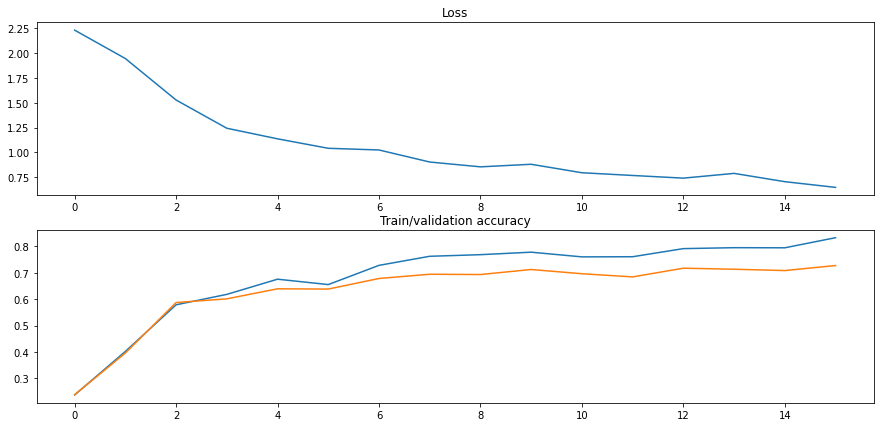

In [27]:
plt.figure(figsize=(15, 7))
plt.subplot(211)
plt.title("Loss")
plt.plot(loss_history)
plt.subplot(212)
plt.title("Train/validation accuracy")
plt.plot(train_history)
plt.plot(val_history)

# Как обычно, посмотрим, как наша лучшая модель работает на тестовых данных

In [28]:
test_pred = best_classifier.predict(test_X)
test_accuracy = multiclass_accuracy(test_pred, test_y)
print('Neural net test set accuracy: %f' % (test_accuracy, ))

Neural net test set accuracy: 0.679000
